Żródło danych: 


*   https://github.com/maryanoo/NLP-ekolo




In [ ]:
!pip install --upgrade spacy

In [ ]:
!pip install --upgrade tables

In [ ]:
!python -m spacy download pl_core_news_lg

In [ ]:
import spacy
nlp = spacy.load("pl_core_news_lg")

In [ ]:
#!python -m pip install morfeusz2

In [ ]:
#import morfeusz2
#morf = morfeusz2.Morfeusz()

In [ ]:
!pip install texthero

In [ ]:
!pip install babyplots

In [ ]:
!pip install top2vec

!pip install top2vec[sentence_encoders]
!pip install top2vec[sentence_transformers]
!pip install top2vec[indexing]

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from gensim.utils import simple_preprocess
from collections import Counter
from google.colab import drive
drive.mount('/content/gdrive')
from tqdm import tqdm
import texthero as hero
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from spacy.lang.pl.stop_words import STOP_WORDS
from spacy import displacy
from top2vec import Top2Vec
import top2vec
from babyplots import Babyplot
import umap
%matplotlib inline

Mounted at /content/gdrive
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Wstępna eksploracja

In [ ]:
data = pd.read_excel('gdrive/MyDrive/Colab Notebooks/NLP_budzety_obywatelskie/inputs/budzety_obywatelskie.xlsx', sheet_name='Arkusz1')


In [ ]:
data

rok   ... WSZYSTKO
0      2020  ...        0
1      2020  ...        3
2      2020  ...        0
3      2020  ...        3
4      2020  ...        0
...     ...  ...      ...
23694   NaN  ...        0
23695   NaN  ...        0
23696   NaN  ...        0
23697   NaN  ...        0
23698   NaN  ...        0

[23699 rows x 4 columns]

In [ ]:
# Sprawdzenie braków danych
data["nazwa"].isna().value_counts()

False    23687
True        12
Name: nazwa, dtype: int64

In [ ]:
# Usunięcie wartości pustych
data = data.dropna(subset = ["nazwa"]).copy()

In [ ]:
data

rok   ... WSZYSTKO
0      2020  ...        0
1      2020  ...        3
2      2020  ...        0
3      2020  ...        3
4      2020  ...        0
...     ...  ...      ...
23688  2020  ...        0
23689  2020  ...        1
23690  2020  ...        1
23691  2020  ...        1
23692  2020  ...        0

[23687 rows x 4 columns]

In [ ]:
# Usunięcie spacji po nazwach niektórych kolumn
data.rename(columns={'rok ': 'rok', 'miasto ':'miasto'}, inplace=True)

In [ ]:
data.head(10)

rok  miasto                                              nazwa  WSZYSTKO
0  2020  GDYNIA                                     Projektistatus         0
1  2020  GDYNIA  Doposażenie parku pomiędzy Estakadą Kwiatkowsk...         3
2  2020  GDYNIA  Cykliczne warsztaty dla seniorów z dzielnicy O...         0
3  2020  GDYNIA   Ogród Sąsiedzki przy Dzikim Sadzie, ul. Źródlana         3
4  2020  GDYNIA  Montaż słupów oświetleniowych na chodniku przy...         0
5  2020  GDYNIA  Cotygodniowe weekendowe lekcje tańca towarzysk...         0
6  2020  GDYNIA  Meble miejskie zaprojektowane przez dzieci. Po...         0
7  2020  GDYNIA  Odnowienie podwórek w obrębie ulic Płk. Dąbka,...         1
8  2020  GDYNIA  Poprawa atrakcyjności skweru przy skrzyżowaniu...         5
9  2020  GDYNIA    Radarowe wyświetlacze prędkości na ul. Morskiej         0

In [ ]:
# Występują zdublowane nazwy miast np. WARSZAWA i Warszawa
s1 = sorted([elem.upper() for elem in data['miasto'].unique()])
s2 = sorted(list(set([elem.upper() for elem in data['miasto'].unique()])))
s1==s2

False

In [ ]:
# Wszystkie miasta piszemy wielką literą dla ujednolicenia
data['miasto'] = data['miasto'].map(lambda x: x.upper())

In [ ]:
data.shape

(23687, 4)

In [ ]:
data['rok'].unique()

array([2020, 2019, 2018, '2018/19'], dtype=object)

In [ ]:
# Usunięcie pustych wpisów
# Indeksy do usunięcia
rem_index = data[data['nazwa'].isnull()].index.tolist()
rem_index += data[data['nazwa']=='bd'].index.tolist()
data.drop(data.index[rem_index], inplace=True)

In [ ]:
data.shape

(23670, 4)

In [ ]:
data['nazwa'].dtype

dtype('O')

In [ ]:
# Konwertujemy na string 
data['nazwa'] = data['nazwa'].apply(str)

Standardowa szerokość kolumn: 50 znaków


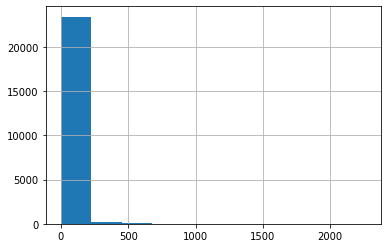

In [ ]:
data['nazwa'].str.len().hist()
print(f"Standardowa szerokość kolumn: {pd.get_option('display.max_colwidth')} znaków")

In [ ]:
#Usuwamy atrybut "WSZYSTKO"
data.drop('WSZYSTKO', inplace=True, axis=1)

In [ ]:
# Wyświetlanie szerszych kolumn, aby nie skracać wyświetlanych nazw tematów
pd.set_option('display.max_colwidth', 500)
data.head(10)

count    23670.000000
mean         8.933629
std          7.469432
min          1.000000
25%          5.000000
50%          7.000000
75%         11.000000
max        294.000000
Name: nazwa, dtype: float64

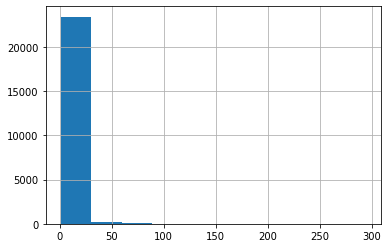

In [ ]:
word_count = data['nazwa'].str.split().map(lambda x: len(x))
word_count.hist()
word_count.describe()

In [ ]:
corpus = []
for x in data['nazwa'].str.split():
    corpus.extend(x)
# Wszystkie słowa są zamienione w listę. Poniżej pierwsze 10 słów
print(corpus[0:10])

['Projektistatus', 'Doposażenie', 'parku', 'pomiędzy', 'Estakadą', 'Kwiatkowskiego', 'a', 'wieżowcami', 'przy', 'ul.']


In [ ]:
# Wyświetlanie najczęściej występujących słów w korpusie
counter=Counter(corpus)
most=counter.most_common()
print(most[0:10]) 

[('i', 6005), ('na', 5857), ('-', 5773), ('dla', 4673), ('ul.', 4530), ('w', 4529), ('przy', 3887), ('do', 2322), ('z', 1961), ('W', 1497)]


In [ ]:
first_n = 40
x, y= [], []
for word,count in most[:first_n]:
        x.append(word)
        y.append(count)

40 najczęściej występujących slów w korpusie


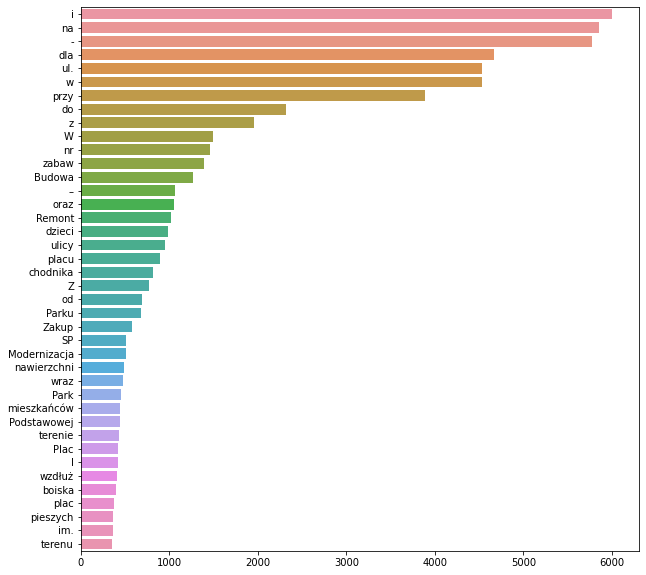

In [ ]:
plt.figure(figsize=(10, 10))
sns.barplot(x=y,y=x)
print(f"{first_n} najczęściej występujących slów w korpusie")

In [ ]:
# Wyświetlanie najczęściej występujących słów w korpusie bez stopwordsów
most_nostop = []
for word, count in most:
    if word.lower() not in STOP_WORDS:
        most_nostop.append((word, count))

40 najczęściej występujących slów w korpusie bez stopwordsów


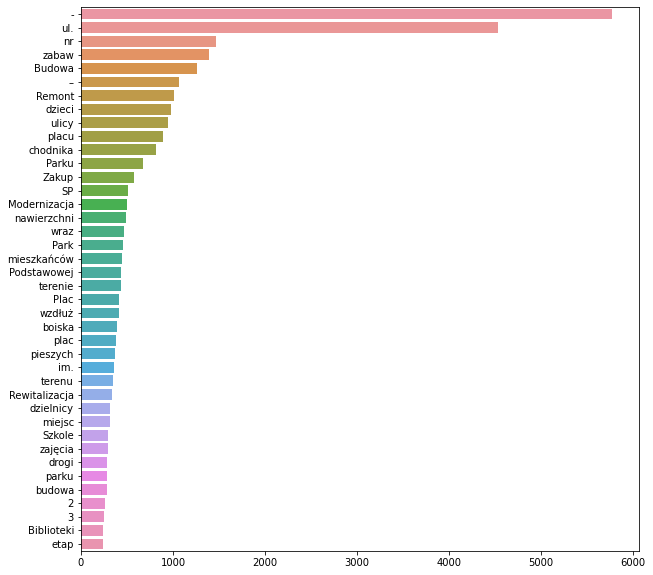

In [ ]:
first_n = 40
x, y= [], []
for word,count in most_nostop[:first_n]:
        x.append(word)
        y.append(count)

plt.figure(figsize=(10, 10))
sns.barplot(x=y,y=x)
print(f"{first_n} najczęściej występujących slów w korpusie bez stopwordsów")

In [ ]:
# simple_preprocess z gensima usuwa liczby, interpunkcję, spowadza wszystko
# do małych liter i tworzy z wyrazów listę
data['tokens'] = data['nazwa'].apply(simple_preprocess)

In [ ]:
data.head()

rok  ...                                                                                                                                                                       tokens
0  2020  ...                                                                                                                                                             [projektistatus]
1  2020  ...  [doposażenie, parku, pomiędzy, estakadą, kwiatkowskiego, wieżowcami, przy, ul, dantyszka, siłownię, zewnętrzną, elementy, małej, architektury, pergole, bujane, ławki, itp]
2  2020  ...                                                                                  [cykliczne, warsztaty, dla, seniorów, dzielnicy, obłuże, rozwijające, pamięć, koncentrację]
3  2020  ...                                                                                                                       [ogród, sąsiedzki, przy, dzikim, sadzie, ul, źródlana]
4  2020  ...                                    [montaż, słupów, oświetleniowych, na, chodniku, przy, ul, niskiej, na, odcinku, pomiędzy, ul, bohaterów, getta, warszawskiego, hodowlaną]

[5 rows x 4 columns]

In [ ]:
# Prosty tokenizer, który zwraca lemmę słowa w oparciu o polski korpus spacy'ego.
def my_tokenizer(tokens: str) -> list:
    return [token.lemma_ for token in nlp(tokens)]

data['tokens'] = data['tokens'].apply(lambda x: ' '.join(x)).apply(my_tokenizer)

In [ ]:
corpus = []
for x in data['tokens']:
    corpus.extend(x)
# Poniżej pierwsze 10 słów
print(corpus[0:10])

['projektistatus', 'doposażenie', 'park', 'pomiędzy', 'estakada', 'kwiatkowskiego', 'wieżowiec', 'przy', 'ul', 'dantyszka']


In [ ]:
# Wyświetlanie najczęściej występującyxh słów w korpusie po zastosowaniu simple_preprocess i tokenizacji
counter=Counter(corpus)
most=counter.most_common()
print(most[0:10])        

[('na', 6307), ('ul', 5056), ('dla', 4962), ('przy', 4126), ('do', 2428), ('plac', 2022), ('zabawa', 1923), ('park', 1748), ('budowa', 1724), ('nr', 1713)]


40 najczęściej występujących slów w korpusie


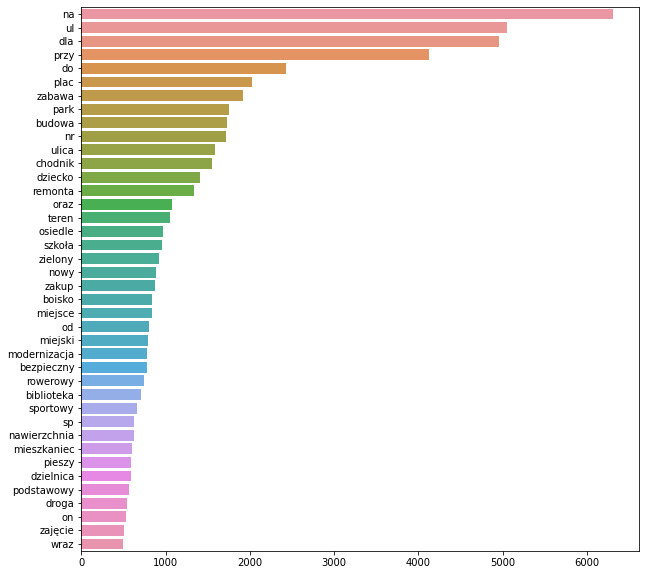

In [ ]:
first_n = 40
x, y= [], []
for word,count in most[:first_n]:
        x.append(word)
        y.append(count)
plt.figure(figsize=(10, 10))
sns.barplot(x=y,y=x)
print(f"{first_n} najczęściej występujących slów w korpusie")

In [ ]:
data.head()

rok  ...                                                                                                                                                                   tokens
0  2020  ...                                                                                                                                                         [projektistatus]
1  2020  ...  [doposażenie, park, pomiędzy, estakada, kwiatkowskiego, wieżowiec, przy, ul, dantyszka, siłownia, zewnętrzny, element, mały, architektura, pergola, bujane, ławka, itp]
2  2020  ...                                                                                 [cykliczny, warsztat, dla, senior, dzielnica, obłuże, rozwijające, pamięć, koncentracja]
3  2020  ...                                                                                                                      [ogród, sąsiedzki, przy, dziki, sadź, ul, źródlany]
4  2020  ...                                            [montaż, słup, oświetleniowy, na, chodnik, przy, ul, niski, na, odcinek, pomiędzy, ul, bohater, getto, warszawski, hodowlany]

[5 rows x 4 columns]

In [ ]:
len(most)

17663

In [ ]:
# Utworzenie listy wszystkich słów według popularności
most_common_words = [token[0] for token in most]
len(most_common_words)

17663

In [ ]:
# Usunięcie z listy wszyskich  STOP_WORDsów
most_common_words = [word for word in most_common_words if word not in STOP_WORDS]
len(most_common_words)

17446

In [ ]:
# Pomocnicza funkcja, która będzie zwracać tokeny tylko o określonej długości
def ret_tokens_with_len(number: int) -> list:
    return [token for token in most_common_words if len(token)==number]

# Rozpakowana lista tokenów o długości 2
tokens_with_len_two = ret_tokens_with_len(2)
print(*tokens_with_len_two)
print('Number of tokens with len 2:', len(tokens_with_len_two))

ul nr sp ii al pm św os zł lo ks pl cz bm st in sw np pw dz ps sa bd zs oś il tj pn mb dk km jp m² bp wz ak pp wg mp le it dr ew pg kw ch pt cm ów kd bł ab zt sz xx nt si vr sm wc pd up as zl śl ro vs zk cd em dł rz ww bb sq hr li zh mx tz qr mł ca om cc bl kl xc ue fu uw nz gd de dl ge db sb zf uś ai re mk ah ui cs el ob ya cn dw oi ws xl rc kr ut ba ne ct me of uł sy dh gr ds pr is et nż gp dj tą dt
Number of tokens with len 2: 135


In [ ]:
# Przegląd częstości występowania tokensów o długości 2
# Subiektywny osąd tokenów i uznanie ich za nieznaczących, małoistotnych
# lub za błędy w tokenizacji.
[(token,n) for token, n in most if token in tokens_with_len_two]

[('ul', 5056),
 ('nr', 1713),
 ('sp', 625),
 ('ii', 287),
 ('al', 228),
 ('pm', 165),
 ('św', 86),
 ('os', 79),
 ('zł', 74),
 ('lo', 68),
 ('ks', 67),
 ('pl', 45),
 ('cz', 38),
 ('bm', 37),
 ('st', 31),
 ('in', 27),
 ('sw', 23),
 ('np', 22),
 ('pw', 20),
 ('dz', 20),
 ('ps', 20),
 ('sa', 17),
 ('bd', 16),
 ('zs', 15),
 ('oś', 15),
 ('il', 12),
 ('tj', 11),
 ('pn', 10),
 ('mb', 10),
 ('dk', 10),
 ('km', 9),
 ('jp', 9),
 ('m²', 9),
 ('bp', 7),
 ('wz', 7),
 ('ak', 7),
 ('pp', 7),
 ('wg', 6),
 ('mp', 6),
 ('le', 6),
 ('it', 6),
 ('dr', 6),
 ('ew', 6),
 ('pg', 6),
 ('kw', 5),
 ('ch', 5),
 ('pt', 5),
 ('cm', 5),
 ('ów', 5),
 ('kd', 5),
 ('bł', 5),
 ('ab', 4),
 ('zt', 4),
 ('sz', 4),
 ('xx', 4),
 ('nt', 4),
 ('si', 4),
 ('vr', 3),
 ('sm', 3),
 ('wc', 3),
 ('pd', 3),
 ('up', 3),
 ('as', 3),
 ('zl', 3),
 ('śl', 3),
 ('ro', 3),
 ('vs', 3),
 ('zk', 3),
 ('cd', 3),
 ('em', 3),
 ('dł', 3),
 ('rz', 3),
 ('ww', 2),
 ('bb', 2),
 ('sq', 2),
 ('hr', 2),
 ('li', 2),
 ('zh', 2),
 ('mx', 2),
 ('tz', 2),
 (

In [ ]:
# Pomocny przy subiektywnej ocenie tokenów może być podgląd rekordów za pomocą poniższej funkcji
data[data['nazwa'].str.contains('ii')].head()

rok  ...                                                                                                                                                                           tokens
17   2020  ...           [budowa, oświetlenie, wzdłuż, starodworcowej, poprawa, bezpieczeństwo, pieszy, na, gryf, pomorski, zwinisławy, źródło, marii, uspokojenie, rucho, na, ulica, górniczy]
27   2020  ...                                                                         [doposażenie, plac, zabawa, gdyni, przy, ul, źródło, marii, huśtawka, bez, oparcie, dla, dziecko, stary]
113  2020  ...                                                                                                                    [kurs, kaligrafia, odręczny, pisanie, dla, dziecko, młodzież]
135  2020  ...                                                                                        [kurs, rysunek, malarstwo, elementy, historia, sztuka, na, pustka, cisowskich, demptowie]
359  2020  ...  [skwer, kościuszki, utworzenie, dwa, równoległy, przejście, dla, pieszy, jako, połączenie, ciąg, spacerowy, linia, prosty, od, ulica, świętojański, do, pomnik, polski, morski]

[5 rows x 4 columns]

In [ ]:
# Zostawiamy wstępnie te tokeny
exclude_from_2 = ['ul', 'sp', 'zł', 'pl', 'oś', 'm²', 'al', 'lo', 'pm', 'pp']

# ul - ulica
# sp - szkoła podstawowa
# zł - informacja o potencjalnym koszcie inwestycji
# pl - plac
# oś - inwestycja posiada oświetlenie - uwaga, wyszukiwać ze spacją ' oś'
# m² - powierzchnia
# al - aleja
# lo - Liceum Ogólnoształcące
# pm - przedszkole miejskie
# pp - przedszkole publiczne (WIELKIMI LITERAMI)

In [ ]:
# Zakładamy, że dwuliterowe tokeny (z kilkoma wyjątkami) to szum (błędy przy tokenizacji)
# Sprawdźmy czy jest ich dużo w naszym zbiorze (wyłączając listę z wyjątkami)

noise = [elem for elem in ret_tokens_with_len(2) if elem not in exclude_from_2]
[elem for elem in most if elem[0] in noise]

[('nr', 1713),
 ('ii', 287),
 ('św', 86),
 ('os', 79),
 ('ks', 67),
 ('cz', 38),
 ('bm', 37),
 ('st', 31),
 ('in', 27),
 ('sw', 23),
 ('np', 22),
 ('pw', 20),
 ('dz', 20),
 ('ps', 20),
 ('sa', 17),
 ('bd', 16),
 ('zs', 15),
 ('il', 12),
 ('tj', 11),
 ('pn', 10),
 ('mb', 10),
 ('dk', 10),
 ('km', 9),
 ('jp', 9),
 ('bp', 7),
 ('wz', 7),
 ('ak', 7),
 ('wg', 6),
 ('mp', 6),
 ('le', 6),
 ('it', 6),
 ('dr', 6),
 ('ew', 6),
 ('pg', 6),
 ('kw', 5),
 ('ch', 5),
 ('pt', 5),
 ('cm', 5),
 ('ów', 5),
 ('kd', 5),
 ('bł', 5),
 ('ab', 4),
 ('zt', 4),
 ('sz', 4),
 ('xx', 4),
 ('nt', 4),
 ('si', 4),
 ('vr', 3),
 ('sm', 3),
 ('wc', 3),
 ('pd', 3),
 ('up', 3),
 ('as', 3),
 ('zl', 3),
 ('śl', 3),
 ('ro', 3),
 ('vs', 3),
 ('zk', 3),
 ('cd', 3),
 ('em', 3),
 ('dł', 3),
 ('rz', 3),
 ('ww', 2),
 ('bb', 2),
 ('sq', 2),
 ('hr', 2),
 ('li', 2),
 ('zh', 2),
 ('mx', 2),
 ('tz', 2),
 ('qr', 2),
 ('mł', 2),
 ('ca', 2),
 ('om', 2),
 ('cc', 2),
 ('bl', 2),
 ('kl', 2),
 ('xc', 2),
 ('ue', 2),
 ('fu', 2),
 ('uw', 2),
 ('

In [ ]:
# Dołączmy szum do stopwordsów
all_stop_words = set.union(STOP_WORDS, set([elem for elem in ret_tokens_with_len(2) if elem not in exclude_from_2]))
len(all_stop_words)

506

In [ ]:
# Czyścimy nasze tokeny ze STOP_WORDsów
data['tokens'] = data['tokens'].apply(lambda x: [token for token in x if token not in all_stop_words])

In [ ]:
data.head()

rok  ...                                                                                                                                                             tokens
0  2020  ...                                                                                                                                                   [projektistatus]
1  2020  ...  [doposażenie, park, pomiędzy, estakada, kwiatkowskiego, wieżowiec, ul, dantyszka, siłownia, zewnętrzny, element, mały, architektura, pergola, bujane, ławka, itp]
2  2020  ...                                                                                [cykliczny, warsztat, senior, dzielnica, obłuże, rozwijające, pamięć, koncentracja]
3  2020  ...                                                                                                                      [ogród, sąsiedzki, dziki, sadź, ul, źródlany]
4  2020  ...                                                    [montaż, słup, oświetleniowy, chodnik, ul, niski, odcinek, pomiędzy, ul, bohater, getto, warszawski, hodowlany]

[5 rows x 4 columns]

In [ ]:
# Wyświetlanie najczęściej występujących słów w korpusie po usunięciu stopwordsów
cnt = Counter()
data['tokens'].map(cnt.update)
most = cnt.most_common()

40 najczęściej występujących slów w korpusie


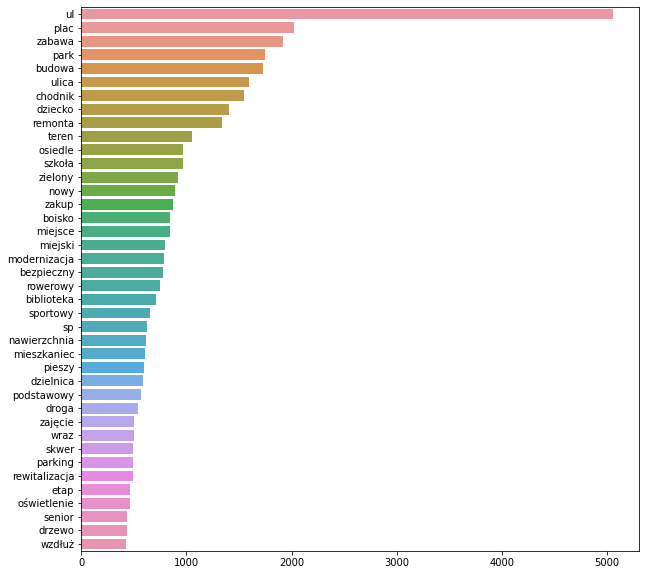

In [ ]:
first_n = 40
x, y= [], []
for word,count in most[:first_n]:
        x.append(word)
        y.append(count)
plt.figure(figsize=(10, 10))
sns.barplot(x=y,y=x)
print(f"{first_n} najczęściej występujących slów w korpusie")

In [ ]:
# Łączymy przetworzone tokeny w stringi
data['names_cleaned'] = data['tokens'].map(lambda x: ' '.join(x))
data.head()

rok  ...                                                                                                                                    names_cleaned
0  2020  ...                                                                                                                                   projektistatus
1  2020  ...  doposażenie park pomiędzy estakada kwiatkowskiego wieżowiec ul dantyszka siłownia zewnętrzny element mały architektura pergola bujane ławka itp
2  2020  ...                                                                       cykliczny warsztat senior dzielnica obłuże rozwijające pamięć koncentracja
3  2020  ...                                                                                                           ogród sąsiedzki dziki sadź ul źródlany
4  2020  ...                                                montaż słup oświetleniowy chodnik ul niski odcinek pomiędzy ul bohater getto warszawski hodowlany

[5 rows x 5 columns]

In [ ]:
# Dla porównania zróbmy czyszczenie dannych z użyciem poniżchych funkcji:
def clean_with_spacy(spacy_doc):
    tokens_cl = [str(token.lemma_.lower()) for token in spacy_doc 
                 if not any([token.is_punct, token.is_stop, token.like_num, token.is_currency, token.like_email, not(token.is_alpha), token in all_stop_words])]
    return " ".join(tokens_cl).strip()

In [ ]:
def spacy_pipeline(dataframe, text_col):
    text_cleaned = []
    for doc in tqdm(nlp.pipe(dataframe[text_col])):
        text_cleaned.append(clean_with_spacy(doc))
    return text_cleaned
data["cleaned_text"] = spacy_pipeline(data, "nazwa")

23670it [00:48, 484.11it/s]


In [ ]:
data = data.reset_index()
del data['index']

In [ ]:
data.to_hdf('gdrive/MyDrive/Colab Notebooks/NLP_budzety_obywatelskie/outputs/budzety_clean.hd5', key='data')

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:2449: PerformanceWarning:


your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block0_values] [items->Index(['rok', 'miasto', 'nazwa', 'tokens', 'names_cleaned', 'cleaned_text'], dtype='object')]




## Chmura słów


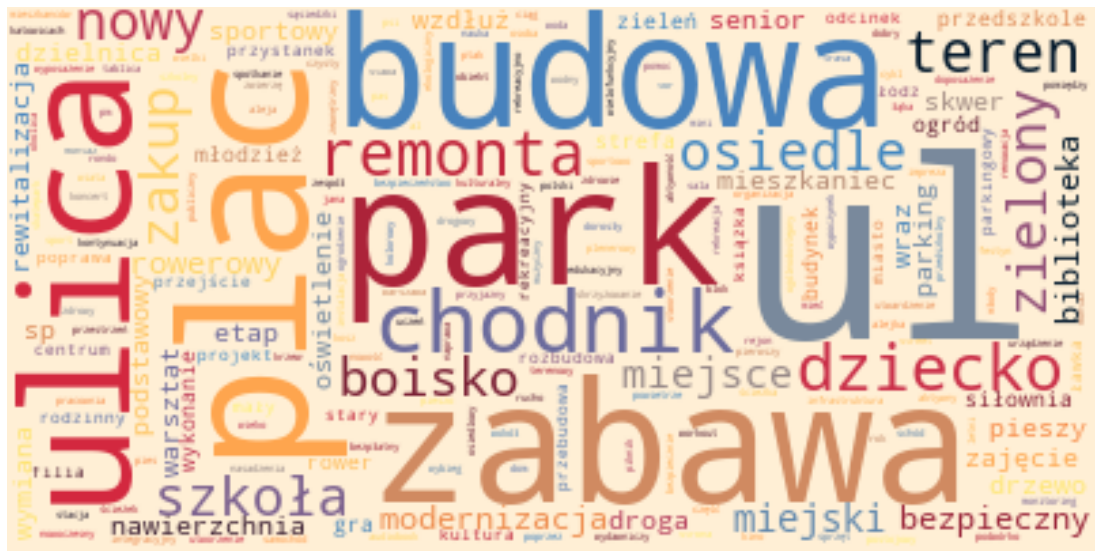

In [ ]:
hero.visualization.wordcloud(data['names_cleaned'])

## Częstość wystąpień n-gramów w zbiorze


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
def get_top_ngram(corpus, n=2, top_ngrams=10):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:top_ngrams]

In [ ]:
top_ngr = 15
bigrams = get_top_ngram(data["nazwa"], top_ngrams=top_ngr)

15 najczęściej występujących bigramów w korpusie przed czyszczeniem danych


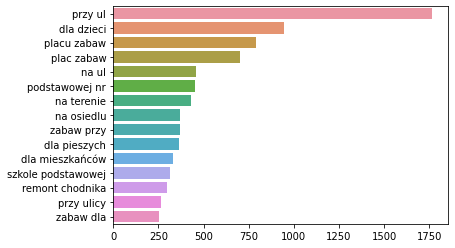

In [ ]:
x,y=map(list,zip(*bigrams))
sns.barplot(x=y,y=x)
print(f"{top_ngr} najczęściej występujących bigramów w korpusie przed czyszczeniem danych")

15 najczęściej występujących bigramów w korpusie po czyszczeniu danych


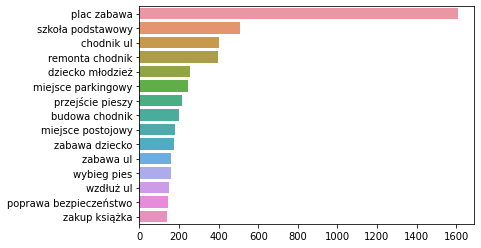

In [ ]:
bigrams = get_top_ngram(data["names_cleaned"], top_ngrams=top_ngr)
x,y=map(list,zip(*bigrams))
sns.barplot(x=y,y=x)
print(f"{top_ngr} najczęściej występujących bigramów w korpusie po czyszczeniu danych")

15 najczęściej występujących trigramów w korpusie przed czyszczeniem danych


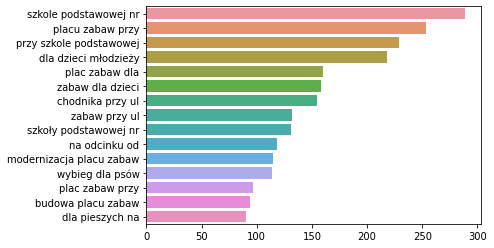

In [ ]:
trigrams = get_top_ngram(data["nazwa"], n=3, top_ngrams=top_ngr)
x,y=map(list,zip(*trigrams))
sns.barplot(x=y,y=x)
print(f"{top_ngr} najczęściej występujących trigramów w korpusie przed czyszczeniem danych")

15 najczęściej występujących trigramów w korpusie po czyszczeniu danych


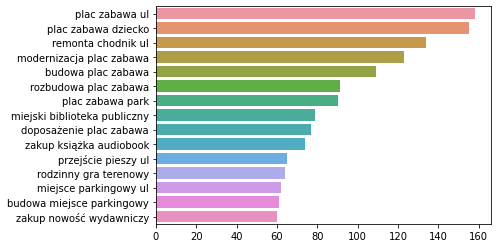

In [ ]:
trigrams = get_top_ngram(data["names_cleaned"], n=3, top_ngrams=top_ngr)
x,y=map(list,zip(*trigrams))
sns.barplot(x=y,y=x)
print(f"{top_ngr} najczęściej występujących trigramów w korpusie po czyszczeniu danych")

##NER

In [ ]:
for i in zip(data['nazwa'], range(10)): 
  doc = nlp(i[0])
  displacy.render(doc, style="ent", jupyter=True)

/usr/local/lib/python3.7/dist-packages/spacy/displacy/__init__.py:200: UserWarning:

[W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.



##Grupowanie danych

In [ ]:
path = 'gdrive/MyDrive/Colab Notebooks/NLP_budzety_obywatelskie/'

In [ ]:
data = pd.read_hdf(path+'outputs/budzety_clean.hd5', key='data')

In [ ]:
data.head()

rok  ...                                       cleaned_text
0  2020  ...                                     projektistatus
1  2020  ...  doposażenie park pomiędzy estakada kwiatkowski...
2  2020  ...  cykliczny warsztat senior dzielnica obłuże roz...
3  2020  ...             ogród sąsiedzki dziki sadź ul źródlany
4  2020  ...  montaż słup oświetleniowy chodnik ul niski odc...

[5 rows x 6 columns]

In [ ]:
docs = list(data.loc[:, 'names_cleaned'].values)
docs = [str(elem) for elem in docs] 

In [ ]:
# Grupowanie danych na tematy
model = Top2Vec(docs, embedding_model='distiluse-base-multilingual-cased')

2022-01-17 23:28:02,462 - top2vec - INFO - Pre-processing documents for training
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.

2022-01-17 23:28:03,438 - top2vec - INFO - Downloading distiluse-base-multilingual-cased model
2022-01-17 23:28:18,655 - top2vec - INFO - Creating joint document/word embedding
2022-01-17 23:43:01,001 - top2vec - INFO - Creating lower dimension embedding of documents
2022-01-17 23:43:33,247 - top2vec - INFO - Finding dense areas of documents
2022-01-17 23:43:36,590 - top2vec - INFO - Finding topics


In [ ]:
model.save(path+'outputs/main_top2vec_topic.model')

In [ ]:
# Ładowanie wcześniej wytrenowanego modelu
model = Top2Vec.load(path+'outputs/main_top2vec_topic.model')

In [ ]:
# Łącznie mamy tyle tematów
model.get_num_topics()

283

In [ ]:
# Ograniczamy liczbę tematów do 30
N_TOPICS = 30
model.hierarchical_topic_reduction(N_TOPICS)

[[218,
  96,
  41,
  133,
  254,
  34,
  280,
  201,
  220,
  30,
  174,
  239,
  50,
  210,
  89,
  275,
  177,
  140,
  143,
  112,
  121,
  213,
  206,
  248,
  216,
  153,
  164,
  205,
  211,
  195,
  215,
  217,
  233,
  256,
  261,
  277,
  0],
 [232,
  19,
  86,
  156,
  237,
  29,
  117,
  28,
  203,
  204,
  32,
  82,
  105,
  176,
  240,
  223,
  92,
  80,
  178,
  151,
  160,
  158,
  251,
  49,
  124,
  214,
  146,
  131,
  249,
  172,
  91,
  168,
  149,
  197,
  130,
  134,
  279,
  252,
  194,
  7],
 [20,
  225,
  119,
  188,
  245,
  18,
  269,
  125,
  199,
  175,
  113,
  118,
  144,
  179,
  207,
  243,
  272,
  3],
 [258, 173, 212, 79, 25, 97, 244, 61, 150, 40, 54, 68, 142, 9],
 [45, 100, 81, 276, 129, 166, 167, 190, 247, 1],
 [132, 27, 33, 191, 59, 75, 271, 2],
 [31, 253, 62, 273, 70, 48, 60, 200, 13],
 [163, 281, 183, 103, 58, 94, 55, 95, 266, 110, 137, 182, 222, 229, 37],
 [185, 224, 8],
 [74, 69, 73, 15],
 [67, 14],
 [138, 242, 16, 127, 65, 76, 93, 180, 171],
 

In [ ]:
# Wyciągamy numery tematów, słowa należące do tematów oraz wyniki podobieństwa słów
topic_words, word_scores, topic_nums = model.get_topics(reduced=True)

In [ ]:
topic_nums

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])

In [ ]:
# Podgląd słów stanowiących tematy od 1 do 30
for topic in topic_nums[0:30]:
    model.generate_topic_wordcloud(topic, background_color="black")

Output hidden; open in https://colab.research.google.com to view.

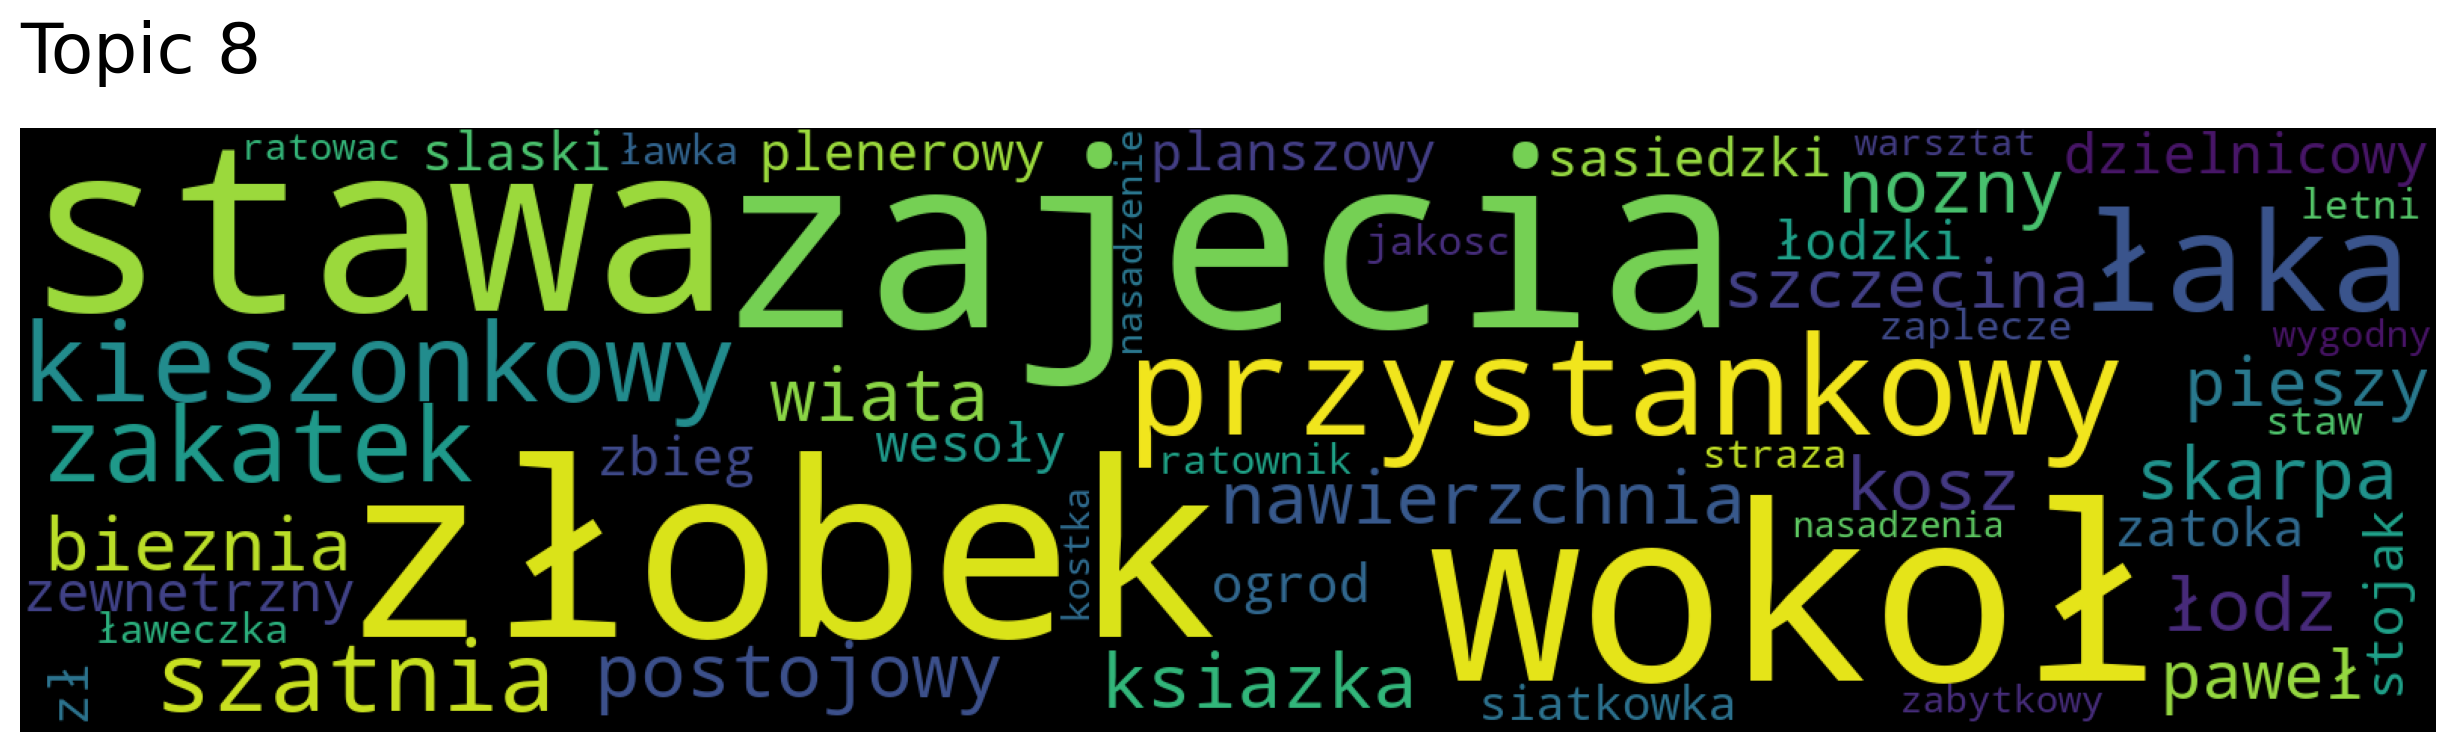

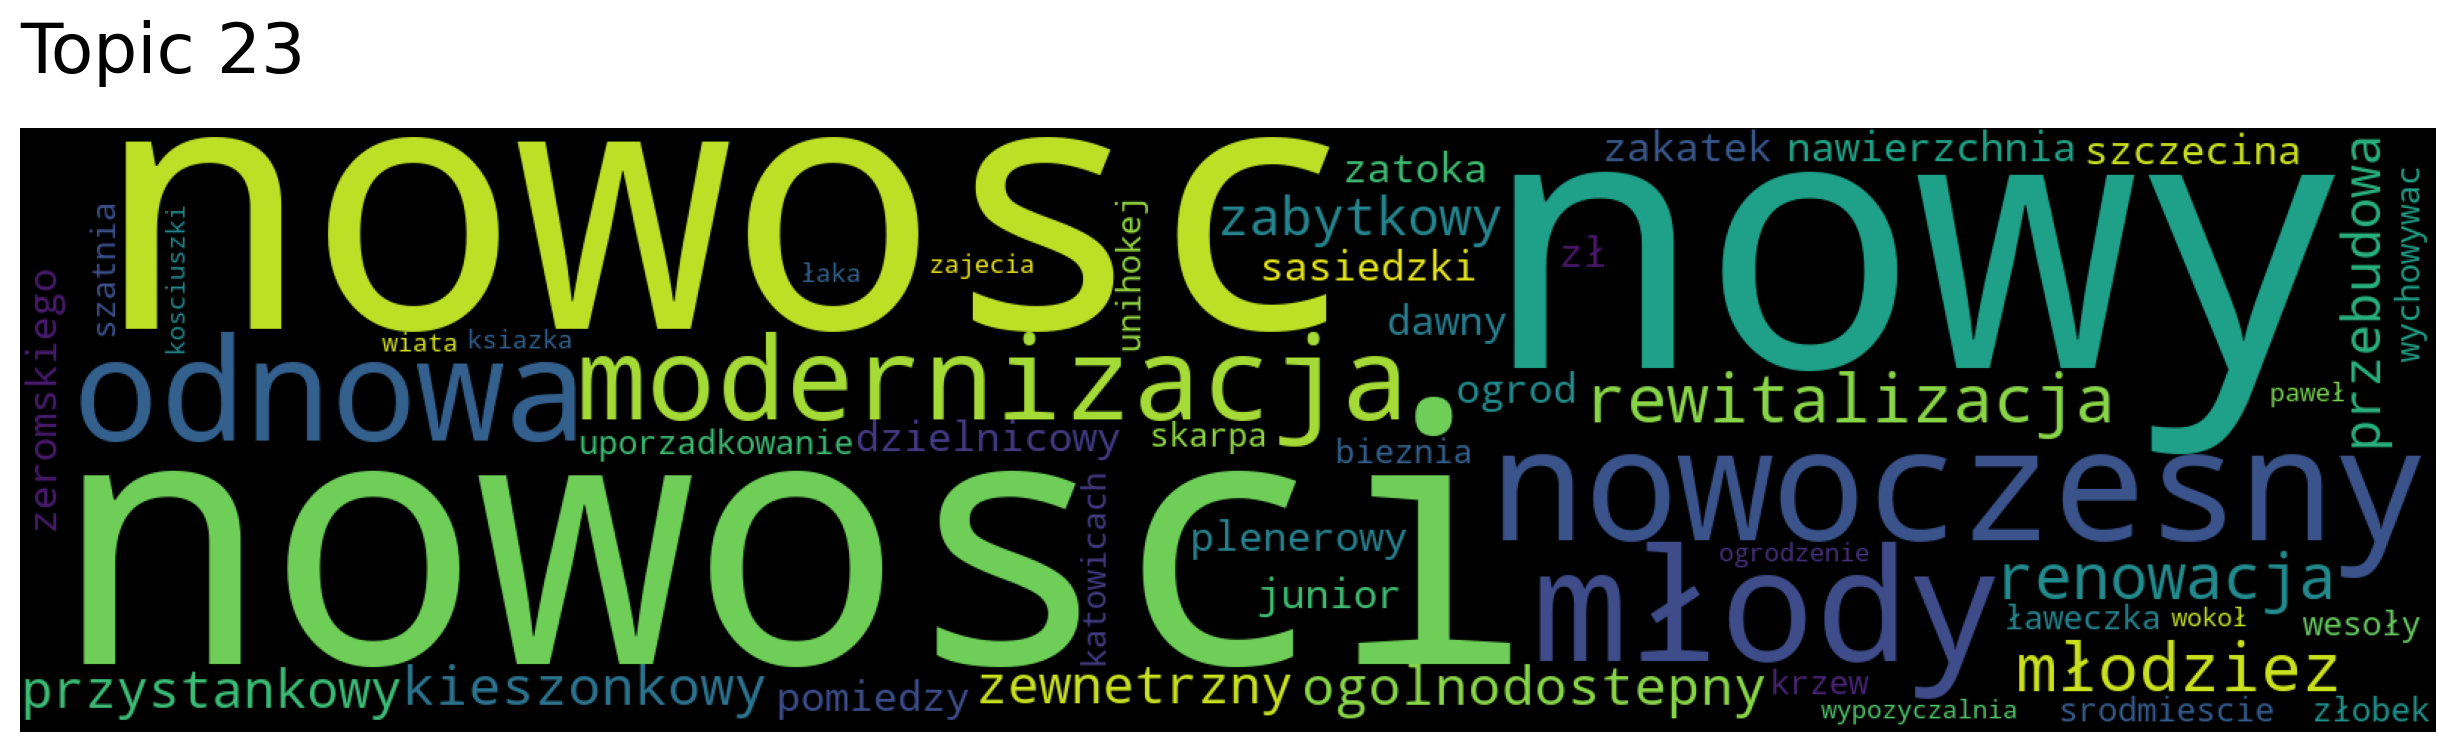

In [ ]:
# Wyszukiwanie tematów po słowach kluczowych
topic_words, word_scores, topic_scores, topic_nums = model.search_topics(keywords=["dziecko", "szkoła"],num_topics=2, reduced=True)
for topic in topic_nums:
    model.generate_topic_wordcloud(topic, background_color="black")

In [ ]:
# Wyszukanie dokumentów najbardziej podobnych do danego tematu
documents, document_scores, document_nums = model.search_documents_by_topic(topic_num=4, num_docs=6, reduced=True)

for doc, score, doc_id in zip(documents, document_scores, document_nums):
    print(f"Document: {doc_id}, Score: {score}")
    print("-----------")
    print(doc)
    print("-----------")
    print()

Document: 13999, Score: 0.9203293919563293
-----------
rowerowy pita stopa osiedle chojny
-----------

Document: 1432, Score: 0.9191768765449524
-----------
połączenie rowerowy ul bolesława krzywoustego śląska
-----------

Document: 13223, Score: 0.9173309206962585
-----------
ucywilizowanie wjazd krawężnik wózek rower
-----------

Document: 936, Score: 0.9129509329795837
-----------
wykonanie pasy rowerowy ul polanka
-----------

Document: 14515, Score: 0.910438060760498
-----------
rower wzdłuż brzeziński zapewnienie ciągłość droga rowerowy
-----------

Document: 2541, Score: 0.9099180698394775
-----------
droga pieszo rowerowy amelungu ul styczyńskiego
-----------



In [ ]:
# Wyszukanie dokumentów najbardziej związane z danym słowem
documents, document_scores, document_nums = model.search_documents_by_keywords(keywords=["szkoła"], num_docs=8)

for doc, score, doc_id in zip(documents, document_scores, document_nums):
    print(f"Document: {doc_id}, Score: {score}")
    print("-----------")
    print(doc)
    print("-----------")
    print()

Document: 1500, Score: 0.9030797690885404
-----------
sąsiedzki szkoła
-----------

Document: 21988, Score: 0.9018578529701248
-----------
szkoła przyszłość
-----------

Document: 17156, Score: 0.8981565034136154
-----------
szkoła sześć
-----------

Document: 7197, Score: 0.8957929304561344
-----------
szkoła glanc
-----------

Document: 19967, Score: 0.8466686339776661
-----------
droga szkoła
-----------

Document: 17274, Score: 0.8302183288050007
-----------
szkoła podstawa
-----------

Document: 17260, Score: 0.8302183288050007
-----------
szkoła podstawa
-----------

Document: 18215, Score: 0.8152147981607525
-----------
plac szkolny sp
-----------



In [ ]:
# Najbardziej podobne słowa do wskazanego
words, word_scores = model.similar_words(keywords=["dziecko"], keywords_neg=[], num_words=20)

for word, score in zip(words, word_scores):
    print(f"{word} {score}")

dzieciecy 0.8766288465062344
ogrodzenie 0.690752525527063
młody 0.6782345367142963
młodziez 0.6693247235525615
wychowywac 0.6643371482728493
dorosły 0.6628273156499627
stawa 0.6307778052560183
wokoł 0.6291083404772322
piekny 0.6267469546232645
łaka 0.6233309091967925
kieszonkowy 0.6200504145836907
nozny 0.6163019344863171
pies 0.6103533207965877
zielen 0.6096689202206059
mały 0.6081302022946632
kosz 0.6075080616515569
pomiedzy 0.6043333356719369
szczecina 0.6039931742887361
kobieta 0.6037848111613294
ogrod 0.6004200925101063


In [ ]:
# Indeksy wszystkich dokumentów
indeksy = data.index.tolist()

In [ ]:
# Budowanie tematów dla dokumentów
documents_topics = model.get_documents_topics(indeksy, reduced=True)

In [ ]:
# Zapisanie tematów do DataFrame'a
data['topics'] = documents_topics[0]

In [ ]:
data['topics_desc'] = pd.DataFrame(documents_topics[2]).agg(' '.join, axis=1).agg(lambda x: x.split())

In [ ]:
data.to_hdf(path+'outputs/budzety_clean_topics_top2vec.h5', key='data')

In [ ]:
# Wyciągamy reprezentację wektorową z dokumentów
X = model._get_document_vectors()
y = data['topics'].values

In [ ]:
X.shape

(23670, 512)

In [ ]:
# Redukujemy do 3 wymiarów
reducer = umap.UMAP(random_state=0, n_components=3)
reducer.fit(X)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning:

The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.



UMAP(n_components=3, random_state=0, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [ ]:
emb = reducer.transform(X)

In [ ]:
# Wizualizacja otrzymanych grup
bp = Babyplot()
bp.add_plot(emb.tolist(), 'pointCloud',
           'categories', y.tolist(), {
               'colorScale': 'Set2',
               'showLegend': True,
               'folded': True,
               'showAxes': [True, True, True],
               'axisLabels': ['x', 'y', 'z']
           })

<IPython.core.display.Javascript object>

In [ ]:
bp.save_as_html(path+'outputs/plot_budzety_clean_topics_top2vec.html', fullscreen = True)

In [ ]:
# Ograniczamy liczbę tematów do 3, żeby otrzymać kategorie tematów
N_TOPICS = 3
model.hierarchical_topic_reduction(N_TOPICS)

[[148,
  47,
  26,
  109,
  135,
  66,
  228,
  241,
  270,
  17,
  255,
  51,
  99,
  104,
  259,
  278,
  208,
  145,
  5,
  219,
  56,
  282,
  238,
  122,
  268,
  10,
  74,
  69,
  73,
  15,
  20,
  225,
  119,
  188,
  245,
  18,
  269,
  125,
  199,
  175,
  113,
  118,
  144,
  179,
  207,
  243,
  272,
  3,
  87,
  161,
  155,
  170,
  187,
  12,
  132,
  27,
  33,
  191,
  59,
  75,
  271,
  2,
  90,
  6,
  39,
  126,
  35,
  45,
  100,
  81,
  276,
  129,
  166,
  167,
  190,
  247,
  1,
  88,
  63,
  263,
  192,
  181,
  189,
  196,
  246,
  24,
  198,
  85,
  101,
  11,
  4,
  83,
  115,
  162,
  44,
  42,
  128,
  53,
  232,
  19,
  86,
  156,
  237,
  29,
  117,
  28,
  203,
  204,
  32,
  82,
  105,
  176,
  240,
  223,
  92,
  80,
  178,
  151,
  160,
  158,
  251,
  49,
  124,
  214,
  146,
  131,
  249,
  172,
  91,
  168,
  149,
  197,
  130,
  134,
  279,
  252,
  194,
  7],
 [185,
  224,
  8,
  57,
  36,
  193,
  116,
  157,
  234,
  21,
  235,
  78,
  226,
  257,

In [ ]:
# Wyciągamy numery tematów, słowa należące do tematów oraz wyniki podobieństwa słów
topic_words, word_scores, topic_nums = model.get_topics(reduced=True)

In [ ]:
# Podgląd słów stanowiących kategorie
for topic in topic_nums[0:3]:
    model.generate_topic_wordcloud(topic)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Budowanie kategorii dla dokumentów
documents_topics = model.get_documents_topics(indeksy, reduced=True)
# Zapisanie kategorie do DataFrame'a
data['category'] = documents_topics[0]

In [ ]:
# Po wizualnej analizie można zobaczyć, że jeden temat może być przepisany jednocześnie do róznych kategorii.
data

In [ ]:
# Na podstawie kloczowych słów ręcznie przepisujemy tematy do kategorii:
# SPOŁECZEŃSTWO
# INFRASTRUKTURA
# NATURA
cat = {"SPOŁECZEŃSTWO":[0, 1, 3, 6, 7, 8, 10, 11, 13, 14, 15, 17, 19, 23, 27],
           "INFRASTRUKTURA":[4, 12, 16, 18, 20, 21, 22, 24, 25, 26, 28],
           "NATURA":[2, 5, 9, 29]}
for ct, tps in cat.items():
  for tp in tps:
    data.loc[data["topics"] == tp, "category_name"] = ct


In [ ]:
data

rok  miasto  ... category   category_name
0      2020  GDYNIA  ...        1   SPOŁECZEŃSTWO
1      2020  GDYNIA  ...        0  INFRASTRUKTURA
2      2020  GDYNIA  ...        0  INFRASTRUKTURA
3      2020  GDYNIA  ...        0          NATURA
4      2020  GDYNIA  ...        0  INFRASTRUKTURA
...     ...     ...  ...      ...             ...
23665  2020  KRAKÓW  ...        1   SPOŁECZEŃSTWO
23666  2020  KRAKÓW  ...        0          NATURA
23667  2020  KRAKÓW  ...        2          NATURA
23668  2020  KRAKÓW  ...        0          NATURA
23669  2020  KRAKÓW  ...        1   SPOŁECZEŃSTWO

[23670 rows x 10 columns]

In [ ]:
data.to_hdf(path+'outputs/budzety_clean_topics_top2vec.h5', key='data')

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:2449: PerformanceWarning:


your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block1_values] [items->Index(['rok', 'miasto', 'nazwa', 'tokens', 'names_cleaned', 'cleaned_text',
       'topics_desc', 'category_name'],
      dtype='object')]




In [ ]:
path = 'gdrive/MyDrive/Colab Notebooks/NLP_budzety_obywatelskie/'

In [ ]:
data = pd.read_hdf(path+'outputs/budzety_clean_topics_top2vec.h5', key='data')

## Wizualizacja otrzymanych wyników

In [ ]:
new_data = data[['nazwa', 'topics', 'category', 'category_name']]

In [ ]:
new_data.iloc[1000:1100]

nazwa  ...   category_name
1000                                                                                      Zieleń w Dzielnicy Młyniska: w ciągu ulicy Marynarki Polskiej, przy Pętli Kliniczna oraz róg ulicy Twardej i Okrąg.  ...  INFRASTRUKTURA
1001  AKTYWNA ZIELONA MATARNIA - Klukowo, Matarnia, Złota Karczma 1. Park kieszonkowy „Łąka Maternusa” MATARNIA (3 etap) 2. "Leśny zakątek za ekranami" MUZYCZNE 3. Ścieżka sensoryczna SP82 KLUKOWO (3 etap)  ...          NATURA
1002                                                                                                                                                    Czysty Nowy Port - nowe kosze śmietnikowe w dzielnicy  ...  INFRASTRUKTURA
1003                                                                                                                                                                               Zestaw fitness pod chmurką  ...   SPOŁECZEŃSTWO
1004                                                                                                                                                                  Wykonanie dojścia do ' PARKU na ZBOCZU'  ...          NATURA
...                                                                                                                                                                                                       ...  ...             ...
1095                                                                   Bylinowa aleja stanowiąca uatrakcyjnienie ciągu pieszego od osiedla przy Kurpińskiego do budynków Zespołu Szkolno Przedszkolnego nr 2.  ...   SPOŁECZEŃSTWO
1096                                                                                                                          Renowacja istniejących placów zabaw na Żabiance przy ul. Sztormowej i Rybackiej  ...   SPOŁECZEŃSTWO
1097                                                                                                                                                            Skwer sąsiedzki na rogu ulic Sosnowa/Batorego  ...  INFRASTRUKTURA
1098                                                                                                                                                                         "Zielony zakątek" przy Sołeckiej  ...          NATURA
1099                                                                                                                                                    Plaże dostępne dla wszystkich - 3 kompozytowe podesty  ...   SPOŁECZEŃSTWO

[100 rows x 4 columns]

In [ ]:
data.loc[data["rok"] == '2018', "rok"] = 2018

In [ ]:
years_agg = data.groupby('rok').agg({'miasto':'count', 'category_name':'count'})

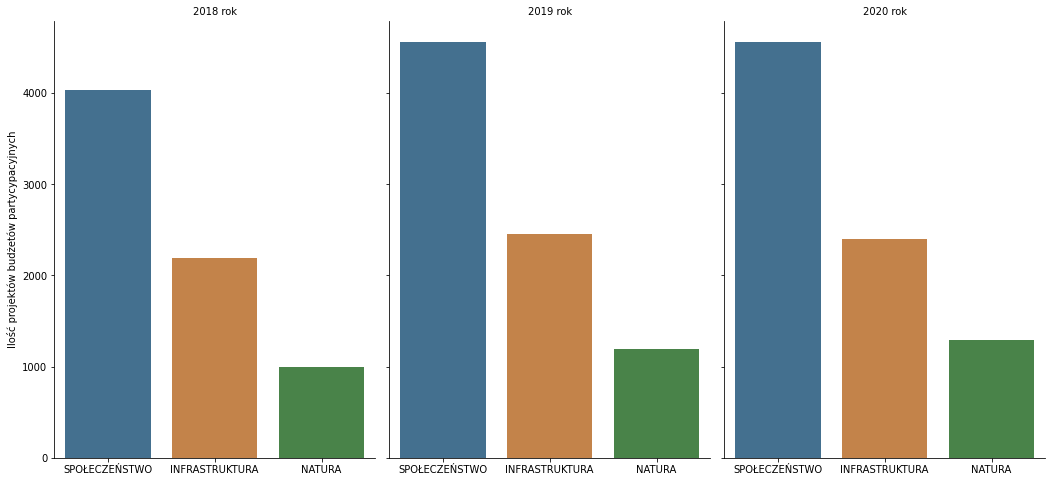

In [ ]:
# Rozkład kategorii inwestycji dla wszystkich gmin w kolejnych latach
(sns.catplot(x="category_name", col='rok',
            data=data, kind="count",
            height=7, aspect=0.7, saturation=0.5)
            .set_axis_labels("", "Ilość projektów budżetów partycypacyjnych")
            .set_titles("{col_name} {col_var}"))
            